In [1]:
# Install necessary Python libraries for GET-Phen implementation
!pip install torch==2.0.1 torchvision torchaudio
!pip install transformers==4.30.2
!pip install networkx==3.1
!pip install scikit-learn==1.2.2
!pip install matplotlib==3.7.1 seaborn==0.12.2
!pip install torch-geometric==2.3.1
!pip install pandas==2.0.3 numpy==1.24.3
!pip install tqdm==4.65.0

# For the physiological simulator, we'll use a lightweight approach
!pip install biopython==1.81  # Basic bioinformatics tools
!pip install pyhrv==0.4.0     # Heart rate variability analysis

# Verify installations
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA device count: {torch.cuda.device_count()}")
if torch.cuda.is_available():
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.0.1+cu117
CUDA available: False
CUDA device count: 0


Generated Smartwatch Data Sample:
                   timestamp  heart_rate       spo2  activity_level  steps  \
0 2025-04-23 10:11:53.696255   77.852110  94.718802        0.610817     11   
1 2025-04-23 10:12:53.696255   73.424308  94.729397        0.699125     16   
2 2025-04-23 10:13:53.696255   77.820678  94.213996        0.221661     10   
3 2025-04-23 10:14:53.696255   76.498102  95.328284        0.261955     16   
4 2025-04-23 10:15:53.696255   80.124402  95.815769        0.297144     16   

  sleep_stage        hrv  age gender   BMI         region  
0       awake  42.555928   45      M  24.5  North America  
1       awake  57.236010   45      M  24.5  North America  
2       awake  37.370502   45      M  24.5  North America  
3       awake  26.589778   45      M  24.5  North America  
4       awake  40.784221   45      M  24.5  North America  


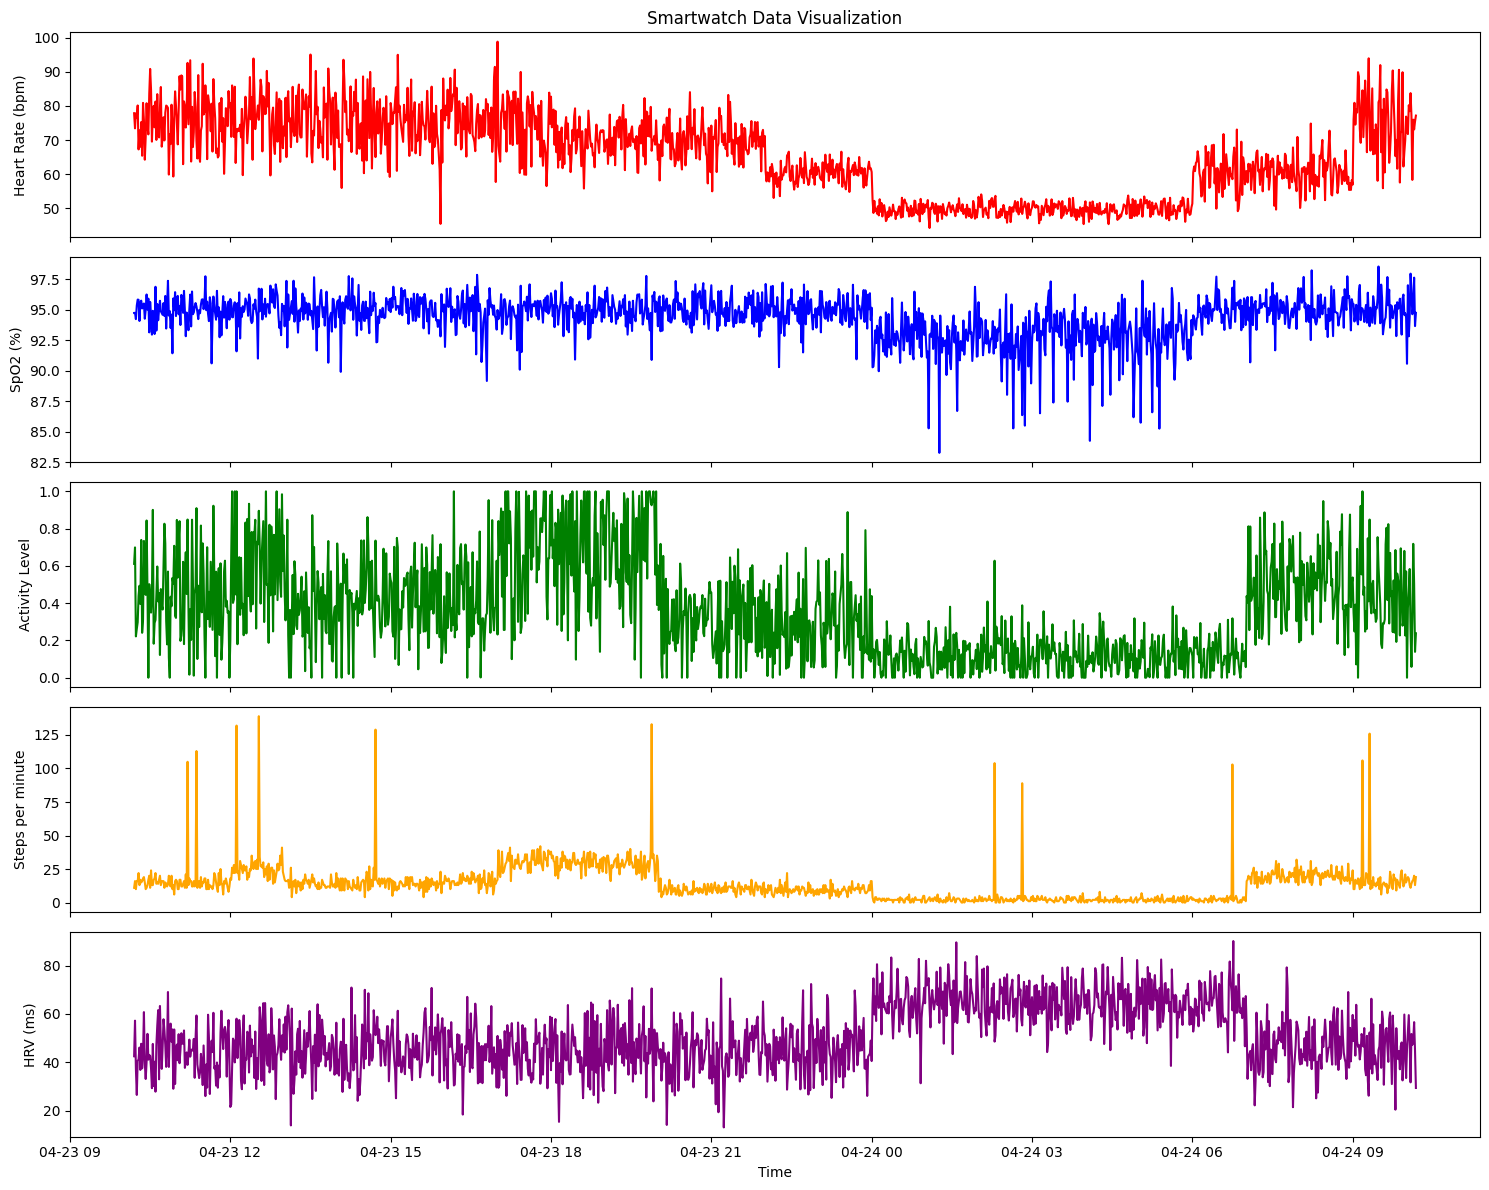

Dataset saved to smartwatch_data.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
import os

class SmartWatchDataGenerator:
    """
    Generates synthetic smartwatch data streams for development and testing.

    This class creates realistic multimodal time series data that mimics common
    smartwatch sensors including PPG/ECG, accelerometer, SpO₂, and more.
    """

    def __init__(self,
                 num_days=7,
                 sampling_rate_per_min=60,  # 1 Hz = 60 samples per minute
                 user_meta=None):
        """
        Initialize the data generator.

        Args:
            num_days: Number of days of data to generate
            sampling_rate_per_min: Samples per minute for high-frequency sensors
            user_meta: Dictionary with user metadata (age, gender, BMI, region)
        """
        self.num_days = num_days
        self.sampling_rate_per_min = sampling_rate_per_min

        # Set default user metadata if none provided
        if user_meta is None:
            self.user_meta = {
                'age': 45,
                'gender': 'M',
                'BMI': 24.5,
                'region': 'North America'
            }
        else:
            self.user_meta = user_meta

        # Create time index
        self.start_time = datetime.now() - timedelta(days=num_days)
        self.timestamps = [self.start_time + timedelta(minutes=i)
                           for i in range(num_days*24*60)]  # 1-min windows

        # Store generated data
        self.data = None

    def generate_heart_rate(self, has_arrhythmia=False):
        """Generate realistic heart rate time series with diurnal patterns."""
        base_hr = 65  # Average resting heart rate
        hr_values = []

        for timestamp in self.timestamps:
            hour = timestamp.hour

            # Diurnal pattern: lower at night, higher during day
            if 0 <= hour < 6:  # Deep sleep
                hr = base_hr - 15 + np.random.normal(0, 2)
            elif 6 <= hour < 9:  # Waking up
                hr = base_hr - 5 + np.random.normal(0, 5)
            elif 9 <= hour < 18:  # Daytime activity
                hr = base_hr + 10 + np.random.normal(0, 8)
            elif 18 <= hour < 22:  # Evening relaxation
                hr = base_hr + 5 + np.random.normal(0, 5)
            else:  # Preparing for sleep
                hr = base_hr - 5 + np.random.normal(0, 3)

            # Add arrhythmia episodes if specified
            if has_arrhythmia and random.random() < 0.03:  # 3% chance of episode
                hr = hr + random.choice([-15, 25]) + np.random.normal(0, 5)

            hr_values.append(max(40, min(180, hr)))  # Enforce physiological limits

        return hr_values

    def generate_spo2(self, has_copd=False):
        """Generate SpO₂ values with optional COPD characteristics."""
        spo2_values = []

        for timestamp in self.timestamps:
            # Healthy baseline with slight variation
            if not has_copd:
                spo2 = 98 + np.random.normal(0, 0.5)
            else:
                # COPD pattern: lower baseline, more variation, occasional drops
                hour = timestamp.hour
                if 0 <= hour < 6:  # Sleep - more desaturations
                    spo2 = 93 + np.random.normal(0, 1.5)
                    # Occasional desaturation events
                    if random.random() < 0.08:  # 8% chance during sleep
                        spo2 -= random.uniform(3, 8)
                else:
                    spo2 = 95 + np.random.normal(0, 1)
                    # Less frequent daytime desaturations
                    if random.random() < 0.02:  # 2% chance during day
                        spo2 -= random.uniform(2, 5)

            spo2_values.append(max(80, min(100, spo2)))  # Enforce physiological limits

        return spo2_values

    def generate_activity(self):
        """Generate activity levels and step counts throughout the day."""
        activity_values = []
        step_counts = []

        for timestamp in self.timestamps:
            hour = timestamp.hour

            # Activity pattern based on time of day
            if 0 <= hour < 7:  # Sleeping
                activity = np.random.normal(0.1, 0.1)
                steps = int(np.random.poisson(2))  # Very few steps
            elif 7 <= hour < 9:  # Morning routine
                activity = np.random.normal(0.5, 0.2)
                steps = int(np.random.poisson(20))
            elif 9 <= hour < 12:  # Morning work/activity
                activity = np.random.normal(0.4, 0.2)
                steps = int(np.random.poisson(15))
            elif 12 <= hour < 13:  # Lunch
                activity = np.random.normal(0.6, 0.2)
                steps = int(np.random.poisson(25))
            elif 13 <= hour < 17:  # Afternoon work/activity
                activity = np.random.normal(0.4, 0.2)
                steps = int(np.random.poisson(15))
            elif 17 <= hour < 20:  # Evening activities
                activity = np.random.normal(0.7, 0.3)
                steps = int(np.random.poisson(30))
            else:  # Evening wind-down
                activity = np.random.normal(0.3, 0.2)
                steps = int(np.random.poisson(10))

            # Add occasional exercise peaks
            if random.random() < 0.01:  # 1% chance of exercise
                activity = min(1.0, activity + random.uniform(0.3, 0.6))
                steps = steps + int(np.random.poisson(100))

            activity_values.append(max(0, min(1, activity)))  # 0-1 scale
            step_counts.append(max(0, steps))

        return activity_values, step_counts

    def generate_sleep_stages(self):
        """Generate sleep stage classifications."""
        sleep_stages = []

        for timestamp in self.timestamps:
            hour = timestamp.hour

            # Sleep stage assignment
            if 0 <= hour < 7:  # Typical sleep hours
                if 0 <= hour < 3:  # First half of night - more deep sleep
                    stages = ['deep', 'light', 'rem']
                    weights = [0.4, 0.4, 0.2]
                else:  # Second half - more REM
                    stages = ['deep', 'light', 'rem']
                    weights = [0.2, 0.5, 0.3]

                sleep_stage = np.random.choice(stages, p=weights)
            else:
                sleep_stage = 'awake'

            sleep_stages.append(sleep_stage)

        return sleep_stages

    def generate_hrv(self, has_diabetes=False):
        """Generate HRV features with optional diabetes characteristics."""
        hrv_values = []

        for timestamp in self.timestamps:
            # Base HRV with diurnal variation
            hour = timestamp.hour
            if 0 <= hour < 7:  # Sleep - higher parasympathetic tone
                base_hrv = 65 + np.random.normal(0, 8)
            else:
                base_hrv = 45 + np.random.normal(0, 10)

            # Diabetes effect - lower HRV due to autonomic dysfunction
            if has_diabetes:
                base_hrv *= 0.7  # 30% reduction
                base_hrv += np.random.normal(0, 5)  # More irregular

            hrv_values.append(max(10, base_hrv))  # Minimum physiological threshold

        return hrv_values

    def generate_full_dataset(self, health_conditions=None):
        """
        Generate a complete multimodal dataset with optional health conditions.

        Args:
            health_conditions: Dictionary of boolean flags for conditions to simulate
                               e.g., {'afib': True, 'copd': False, 'diabetes': False}
        """
        if health_conditions is None:
            health_conditions = {
                'afib': False,
                'copd': False,
                'diabetes': False
            }

        # Generate 1-minute windows of data
        hr_values = self.generate_heart_rate(has_arrhythmia=health_conditions.get('afib', False))
        spo2_values = self.generate_spo2(has_copd=health_conditions.get('copd', False))
        activity_values, step_counts = self.generate_activity()
        sleep_stages = self.generate_sleep_stages()
        hrv_values = self.generate_hrv(has_diabetes=health_conditions.get('diabetes', False))

        # Create complete DataFrame
        self.data = pd.DataFrame({
            'timestamp': self.timestamps,
            'heart_rate': hr_values,
            'spo2': spo2_values,
            'activity_level': activity_values,
            'steps': step_counts,
            'sleep_stage': sleep_stages,
            'hrv': hrv_values
        })

        # Add metadata as separate columns
        for key, value in self.user_meta.items():
            self.data[key] = value

        return self.data

    def save_dataset(self, filename='smartwatch_data.csv'):
        """Save the generated dataset to a CSV file."""
        if self.data is not None:
            self.data.to_csv(filename, index=False)
            print(f"Dataset saved to {filename}")
        else:
            print("No data generated yet. Call generate_full_dataset() first.")

    def visualize_data(self, days=1):
        """Visualize the generated data for a specified number of days."""
        if self.data is None:
            print("No data to visualize. Call generate_full_dataset() first.")
            return

        # Filter to the requested number of days
        days_data = self.data.iloc[:days*24*60]

        # Create figure with subplots
        fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)

        # Plot heart rate
        axes[0].plot(days_data['timestamp'], days_data['heart_rate'], 'r-')
        axes[0].set_ylabel('Heart Rate (bpm)')
        axes[0].set_title('Smartwatch Data Visualization')

        # Plot SpO2
        axes[1].plot(days_data['timestamp'], days_data['spo2'], 'b-')
        axes[1].set_ylabel('SpO2 (%)')

        # Plot activity level
        axes[2].plot(days_data['timestamp'], days_data['activity_level'], 'g-')
        axes[2].set_ylabel('Activity Level')

        # Plot steps
        axes[3].plot(days_data['timestamp'], days_data['steps'], 'orange')
        axes[3].set_ylabel('Steps per minute')

        # Plot HRV
        axes[4].plot(days_data['timestamp'], days_data['hrv'], 'purple')
        axes[4].set_ylabel('HRV (ms)')

        plt.xlabel('Time')
        plt.tight_layout()
        plt.show()


# Generate sample data
# Example: Creating a dataset with COPD characteristics
data_generator = SmartWatchDataGenerator(num_days=7)
data = data_generator.generate_full_dataset(
    health_conditions={'afib': False, 'copd': True, 'diabetes': False}
)

# Display the first few rows
print("Generated Smartwatch Data Sample:")
print(data.head())

# Visualize one day of data
data_generator.visualize_data(days=1)

# Save the dataset
data_generator.save_dataset('smartwatch_data.csv')

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5 - Recon Loss: nan, Contrast Loss: nan, Total Loss: nan
Epoch 2/5 - Recon Loss: nan, Contrast Loss: nan, Total Loss: nan
Epoch 3/5 - Recon Loss: nan, Contrast Loss: nan, Total Loss: nan
Epoch 4/5 - Recon Loss: nan, Contrast Loss: nan, Total Loss: nan
Epoch 5/5 - Recon Loss: nan, Contrast Loss: nan, Total Loss: nan


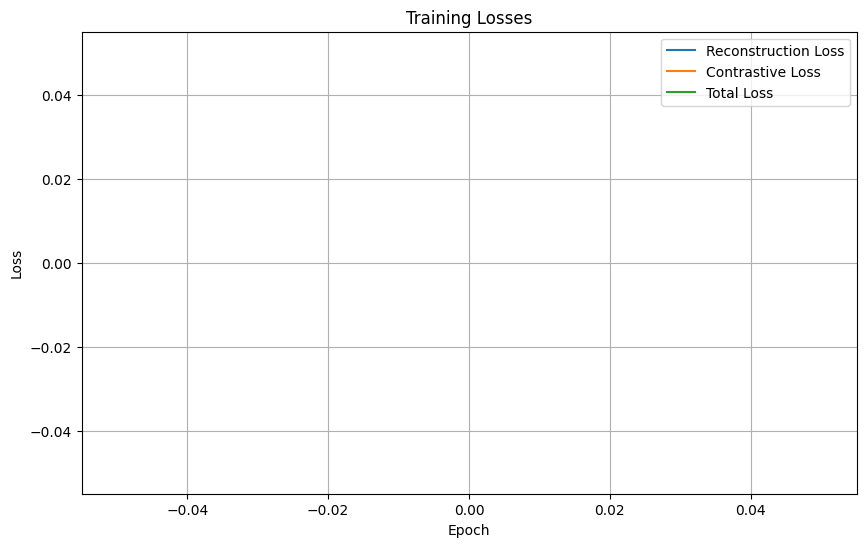

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

class SmartWatchDataset(Dataset):
    """Dataset class for smartwatch multimodal data."""

    def __init__(self, dataframe, sequence_length=10, transform=None):
        """
        Initialize the dataset.

        Args:
            dataframe: Pandas DataFrame with smartwatch data
            sequence_length: Number of time steps in each sequence
            transform: Optional transform to apply to the data
        """
        self.data = dataframe
        self.sequence_length = sequence_length
        self.transform = transform

        # Extract features from dataframe
        self.feature_cols = [
            'heart_rate', 'spo2', 'activity_level', 'steps', 'hrv'
        ]

        # One-hot encode categorical variables
        self.sleep_dummies = pd.get_dummies(self.data['sleep_stage'], prefix='sleep')

        # Combine all numerical features
        self.features = pd.concat([
            self.data[self.feature_cols].reset_index(drop=True),
            self.sleep_dummies.reset_index(drop=True)
        ], axis=1)

        # Scale features
        self.scaler = StandardScaler()
        self.scaled_features = self.scaler.fit_transform(self.features)

        # Create sequences
        self.sequences = []
        for i in range(len(self.scaled_features) - sequence_length + 1):
            self.sequences.append(self.scaled_features[i:i+sequence_length])

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]

        if self.transform:
            sequence = self.transform(sequence)

        # Convert to torch tensor
        sequence_tensor = torch.FloatTensor(sequence)

        return sequence_tensor


class MaskedReconstructionTransform:
    """Transform that randomly masks modalities for reconstruction tasks."""

    def __init__(self, mask_prob=0.15, feature_groups=None):
        """
        Initialize the transform.

        Args:
            mask_prob: Probability of masking a modality
            feature_groups: List of lists indicating feature groups (one per modality)
                           If None, each feature is treated as a separate modality
        """
        self.mask_prob = mask_prob
        self.feature_groups = feature_groups

    def __call__(self, sequence):
        """
        Apply masking to the sequence.

        Args:
            sequence: numpy array of shape (sequence_length, num_features)

        Returns:
            masked_sequence: Sequence with masked features
            mask: Binary mask showing which features were masked (1=masked)
            original: Original sequence for reconstruction target
        """
        # Create a copy of the original sequence
        masked_sequence = sequence.copy()
        original = sequence.copy()

        # Create mask array (same shape as sequence)
        mask = np.zeros_like(sequence)

        if self.feature_groups is None:
            # Treat each feature as a separate modality
            for j in range(sequence.shape[1]):
                if np.random.random() < self.mask_prob:
                    masked_sequence[:, j] = 0  # Mask this feature
                    mask[:, j] = 1  # Mark as masked
        else:
            # Mask by feature groups (modalities)
            for group in self.feature_groups:
                if np.random.random() < self.mask_prob:
                    masked_sequence[:, group] = 0  # Mask this modality
                    mask[:, group] = 1  # Mark as masked

        return masked_sequence, mask, original


class TemporalTransformer(nn.Module):
    """
    Transformer model for self-supervised learning on multimodal smartwatch data.

    This model implements both masked modality reconstruction and
    temporal contrastive learning objectives.
    """

    def __init__(self, input_dim, hidden_dim=128, num_layers=2,
                 num_heads=4, dropout=0.1, latent_dim=200):
        """
        Initialize the temporal transformer.

        Args:
            input_dim: Number of input features
            hidden_dim: Hidden dimension of the transformer
            num_layers: Number of transformer encoder layers
            num_heads: Number of attention heads
            dropout: Dropout probability
            latent_dim: Dimension of the final latent representation
        """
        super(TemporalTransformer, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_layers
        )

        # Projection to latent space
        self.latent_projection = nn.Linear(hidden_dim, latent_dim)

        # Reconstruction head
        self.reconstruction_head = nn.Linear(latent_dim, input_dim)

    def forward(self, x, mask=None):
        """
        Forward pass through the model.

        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            mask: Optional attention mask

        Returns:
            latent: Latent representation of shape (batch_size, seq_len, latent_dim)
            reconstruction: Reconstructed input of shape (batch_size, seq_len, input_dim)
        """
        # Project input to hidden dimension
        x = self.input_projection(x)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Apply transformer encoder
        # If mask is provided, create a padding mask for the transformer
        if mask is not None:
            # Convert binary mask to boolean mask where True means to mask
            transformer_mask = (mask.sum(dim=-1) > 0).bool()
            x = self.transformer_encoder(x, src_key_padding_mask=transformer_mask)
        else:
            x = self.transformer_encoder(x)

        # Project to latent space
        latent = self.latent_projection(x)

        # Reconstruction
        reconstruction = self.reconstruction_head(latent)

        return latent, reconstruction


class PositionalEncoding(nn.Module):
    """Positional encoding for the transformer model."""

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(1)]
        return self.dropout(x)


class ContrastiveLoss(nn.Module):
    """
    Temporal contrastive loss function for self-supervised learning.

    This loss pulls together representations of adjacent time windows
    while pushing apart distant windows.
    """

    def __init__(self, temperature=0.5, time_threshold=3):
        """
        Initialize the contrastive loss.

        Args:
            temperature: Temperature parameter for the loss
            time_threshold: Time threshold in minutes to consider windows as positive pairs
        """
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.time_threshold = time_threshold

    def forward(self, embeddings, timestamps):
        """
        Compute the contrastive loss.

        Args:
            embeddings: Tensor of shape (batch_size, latent_dim)
            timestamps: Tensor of shape (batch_size,) containing timestamp indices

        Returns:
            loss: Contrastive loss value
        """
        # Normalize embeddings
        embeddings = F.normalize(embeddings, p=2, dim=1)

        # Compute similarity matrix
        sim_matrix = torch.matmul(embeddings, embeddings.T) / self.temperature

        # Create mask for positive pairs (adjacent in time)
        time_diffs = torch.abs(timestamps.unsqueeze(0) - timestamps.unsqueeze(1))
        pos_mask = (time_diffs <= self.time_threshold) & (time_diffs > 0)

        # Remove self-similarities from positive mask
        pos_mask.fill_diagonal_(False)

        # Create negative mask (all non-positive pairs)
        neg_mask = ~pos_mask
        neg_mask.fill_diagonal_(False)

        # FIXED: Properly handle the contrastive loss calculation to avoid dimension mismatch
        if pos_mask.sum() > 0:
            # Get the indices where pos_mask is True
            pos_indices = pos_mask.nonzero(as_tuple=True)

            # Extract the similarity scores for positive pairs
            pos_sim = sim_matrix[pos_indices]

            # Compute the denominators for each row (for each anchor)
            exp_sim = torch.exp(sim_matrix)
            denominators = torch.sum(exp_sim, dim=1)

            # Get the denominators for the anchors in positive pairs
            row_indices = pos_indices[0]  # Row indices are the anchors
            denominators_for_pos = denominators[row_indices]

            # Compute loss for positive pairs
            pos_loss = -torch.log(torch.exp(pos_sim) / denominators_for_pos)
            loss = pos_loss.mean()
        else:
            # No positive pairs found, return zero loss
            loss = torch.tensor(0.0, device=embeddings.device)

        return loss


def train_self_supervised_model(dataloader, model, device, num_epochs=10,
                               learning_rate=1e-4, weight_decay=1e-5):
    """
    Train the self-supervised transformer model.

    Args:
        dataloader: DataLoader with smartwatch sequences
        model: TemporalTransformer model
        device: Device to run training on
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer

    Returns:
        model: Trained model
        losses: Dictionary of training losses
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # Define losses
    mse_loss = nn.MSELoss()
    contrastive_loss = ContrastiveLoss()

    # Initialize loss tracking
    losses = {
        'reconstruction': [],
        'contrastive': [],
        'total': []
    }

    for epoch in tqdm(range(num_epochs)):
        epoch_recon_loss = 0
        epoch_contrast_loss = 0
        epoch_total_loss = 0

        model.train()
        for batch in dataloader:
            # Get sequence and apply masking
            sequence = batch.to(device)
            batch_size, seq_len, feat_dim = sequence.shape

            # Create masking for reconstruction task
            mask = torch.zeros_like(sequence).to(device)
            for b in range(batch_size):
                # Randomly select features to mask
                mask_indices = torch.randperm(feat_dim)[:max(1, int(feat_dim * 0.15))]
                mask[b, :, mask_indices] = 1

            # Apply mask to input
            masked_input = sequence * (1 - mask)

            # Forward pass
            latent, reconstruction = model(masked_input, mask)

            # Reconstruction loss (only for masked elements)
            recon_loss = mse_loss(
                reconstruction * mask,
                sequence * mask
            )

            # Contrastive loss
            # Create synthetic timestamps (indices for this example)
            # Using batch_size consecutive indices to represent distinct time points
            timestamps = torch.arange(batch_size, device=device)

            # Use mean of sequence embeddings as the representation for contrastive loss
            mean_embeddings = latent.mean(dim=1)

            # Calculate contrastive loss
            contrast_loss = contrastive_loss(mean_embeddings, timestamps)

            # Total loss
            total_loss = recon_loss + contrast_loss

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            # Update epoch losses
            epoch_recon_loss += recon_loss.item()
            epoch_contrast_loss += contrast_loss.item()
            epoch_total_loss += total_loss.item()

        # Record average epoch losses
        losses['reconstruction'].append(epoch_recon_loss / len(dataloader))
        losses['contrastive'].append(epoch_contrast_loss / len(dataloader))
        losses['total'].append(epoch_total_loss / len(dataloader))

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Recon Loss: {losses['reconstruction'][-1]:.4f}, "
              f"Contrast Loss: {losses['contrastive'][-1]:.4f}, "
              f"Total Loss: {losses['total'][-1]:.4f}")

    return model, losses


# Usage example
# Load the saved smartwatch data
df = pd.read_csv('smartwatch_data.csv')

# Create dataset with sequences of 10 minutes
dataset = SmartWatchDataset(df, sequence_length=10)

# Create data loader for training
from torch.utils.data import DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the transformer model
input_dim = dataset.features.shape[1]  # Number of features after preprocessing
model = TemporalTransformer(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=2,
    num_heads=4,
    dropout=0.1,
    latent_dim=200  # Your target embedding dimension
)

# Train the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model, losses = train_self_supervised_model(
    dataloader,
    model,
    device,
    num_epochs=5  # Reduced for demonstration
)

# Visualize training losses
plt.figure(figsize=(10, 6))
plt.plot(losses['reconstruction'], label='Reconstruction Loss')
plt.plot(losses['contrastive'], label='Contrastive Loss')
plt.plot(losses['total'], label='Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()
plt.grid(True)
plt.show()

# Save the trained model
torch.save(trained_model.state_dict(), 'temporal_transformer.pt')

Using device: cpu


  0%|          | 0/10 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
Early stopping at epoch 6 as loss hasn't improved for 5 epochs


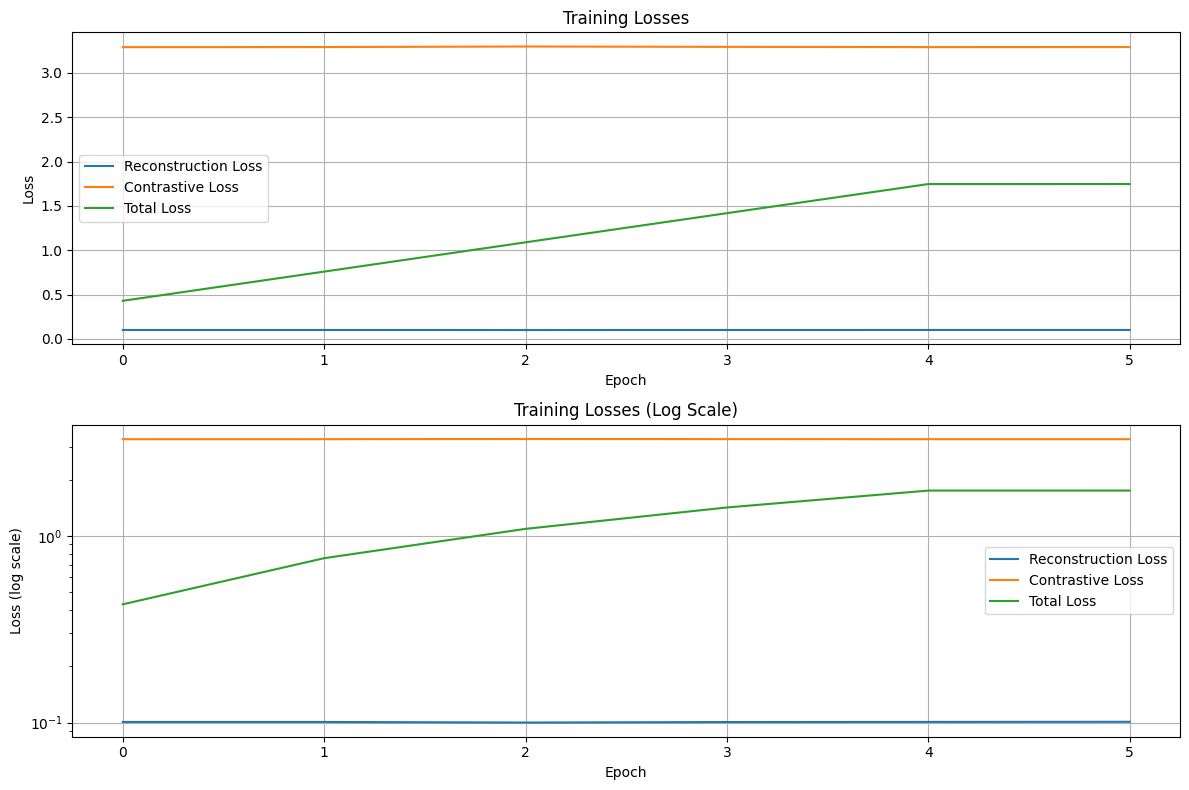

Training completed successfully!


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import math

class SmartWatchDataset(Dataset):
    """Dataset class for smartwatch multimodal data."""

    def __init__(self, dataframe, sequence_length=10, transform=None):
        """
        Initialize the dataset.

        Args:
            dataframe: Pandas DataFrame with smartwatch data
            sequence_length: Number of time steps in each sequence
            transform: Optional transform to apply to the data
        """
        self.data = dataframe
        self.sequence_length = sequence_length
        self.transform = transform

        # Extract features from dataframe
        self.feature_cols = [
            'heart_rate', 'spo2', 'activity_level', 'steps', 'hrv'
        ]

        # One-hot encode categorical variables
        self.sleep_dummies = pd.get_dummies(self.data['sleep_stage'], prefix='sleep')

        # Combine all numerical features
        self.features = pd.concat([
            self.data[self.feature_cols].reset_index(drop=True),
            self.sleep_dummies.reset_index(drop=True)
        ], axis=1)

        # Scale features
        self.scaler = StandardScaler()
        self.scaled_features = self.scaler.fit_transform(self.features)

        # Handle NaN values by replacing with zeros
        self.scaled_features = np.nan_to_num(self.scaled_features, nan=0.0)

        # Filter extreme values to prevent numerical instability
        self._filter_extreme_values()

        # Create sequences
        self.sequences = []
        for i in range(len(self.scaled_features) - sequence_length + 1):
            self.sequences.append(self.scaled_features[i:i+sequence_length])

    def _filter_extreme_values(self, threshold=5.0):
        """Filter extreme values that could cause numerical instability."""
        # Calculate z-scores
        mean = np.mean(self.scaled_features, axis=0, keepdims=True)
        std = np.std(self.scaled_features, axis=0, keepdims=True)
        std = np.maximum(std, 1e-10)  # Avoid division by zero
        z_scores = np.abs((self.scaled_features - mean) / std)

        # Identify extreme values (z-score > threshold)
        extreme_mask = z_scores > threshold
        if np.any(extreme_mask):
            print(f"Warning: Replacing {np.sum(extreme_mask)} extreme values in dataset")
            # Replace extreme values with threshold * std + mean (or -mean for negative)
            sign = np.sign(self.scaled_features - mean)
            self.scaled_features = np.where(
                extreme_mask,
                sign * threshold * std + mean,
                self.scaled_features
            )

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = self.sequences[idx]

        if self.transform:
            sequence = self.transform(sequence)

        # Convert to torch tensor
        sequence_tensor = torch.FloatTensor(sequence)

        return sequence_tensor


class MaskedReconstructionTransform:
    """Transform that randomly masks modalities for reconstruction tasks."""

    def __init__(self, mask_prob=0.15, feature_groups=None):
        """
        Initialize the transform.

        Args:
            mask_prob: Probability of masking a modality
            feature_groups: List of lists indicating feature groups (one per modality)
                           If None, each feature is treated as a separate modality
        """
        self.mask_prob = mask_prob
        self.feature_groups = feature_groups

    def __call__(self, sequence):
        """
        Apply masking to the sequence.

        Args:
            sequence: numpy array of shape (sequence_length, num_features)

        Returns:
            masked_sequence: Sequence with masked features
            mask: Binary mask showing which features were masked (1=masked)
            original: Original sequence for reconstruction target
        """
        # Create a copy of the original sequence
        masked_sequence = sequence.copy()
        original = sequence.copy()

        # Create mask array (same shape as sequence)
        mask = np.zeros_like(sequence)

        if self.feature_groups is None:
            # Treat each feature as a separate modality
            for j in range(sequence.shape[1]):
                if np.random.random() < self.mask_prob:
                    masked_sequence[:, j] = 0  # Mask this feature
                    mask[:, j] = 1  # Mark as masked
        else:
            # Mask by feature groups (modalities)
            for group in self.feature_groups:
                if np.random.random() < self.mask_prob:
                    masked_sequence[:, group] = 0  # Mask this modality
                    mask[:, group] = 1  # Mark as masked

        # Ensure at least one feature is masked
        if not np.any(mask):
            j = np.random.randint(sequence.shape[1])
            masked_sequence[:, j] = 0
            mask[:, j] = 1

        return masked_sequence, mask, original


class TemporalTransformer(nn.Module):
    """
    Transformer model for self-supervised learning on multimodal smartwatch data.

    This model implements both masked modality reconstruction and
    temporal contrastive learning objectives.
    """

    def __init__(self, input_dim, hidden_dim=128, num_layers=2,
                 num_heads=4, dropout=0.1, latent_dim=200):
        """
        Initialize the temporal transformer.

        Args:
            input_dim: Number of input features
            hidden_dim: Hidden dimension of the transformer
            num_layers: Number of transformer encoder layers
            num_heads: Number of attention heads
            dropout: Dropout probability
            latent_dim: Dimension of the final latent representation
        """
        super(TemporalTransformer, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        # Input projection
        self.input_projection = nn.Linear(input_dim, hidden_dim)

        # Positional encoding
        self.pos_encoder = PositionalEncoding(hidden_dim, dropout)

        # Layer normalization for input stabilization
        self.input_norm = nn.LayerNorm(hidden_dim)

        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=hidden_dim,
            nhead=num_heads,
            dim_feedforward=hidden_dim*4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layers,
            num_layers=num_layers
        )

        # Projection to latent space with layer normalization
        self.latent_projection = nn.Linear(hidden_dim, latent_dim)
        self.latent_norm = nn.LayerNorm(latent_dim)

        # Reconstruction head
        self.reconstruction_head = nn.Linear(latent_dim, input_dim)

        # Initialize weights properly
        self._init_weights()

    def _init_weights(self):
        """Initialize weights to avoid exploding/vanishing gradients"""
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        # Special initialization for final reconstruction layer
        nn.init.zeros_(self.reconstruction_head.bias)

    def forward(self, x, mask=None):
        """
        Forward pass through the model.

        Args:
            x: Input tensor of shape (batch_size, seq_len, input_dim)
            mask: Optional attention mask

        Returns:
            latent: Latent representation of shape (batch_size, seq_len, latent_dim)
            reconstruction: Reconstructed input of shape (batch_size, seq_len, input_dim)
        """
        # Check for NaN values in input
        if torch.isnan(x).any():
            x = torch.nan_to_num(x, nan=0.0)

        # Project input to hidden dimension
        x = self.input_projection(x)

        # Apply layer normalization for stability
        x = self.input_norm(x)

        # Add positional encoding
        x = self.pos_encoder(x)

        # Apply transformer encoder
        # If mask is provided, create a padding mask for the transformer
        if mask is not None:
            # Convert binary mask to boolean mask where True means to mask
            transformer_mask = (mask.sum(dim=-1) > 0).bool()
            x = self.transformer_encoder(x, src_key_padding_mask=transformer_mask)
        else:
            x = self.transformer_encoder(x)

        # Project to latent space with normalization
        latent = self.latent_projection(x)
        latent = self.latent_norm(latent)

        # Reconstruction
        reconstruction = self.reconstruction_head(latent)

        return latent, reconstruction


class PositionalEncoding(nn.Module):
    """Positional encoding for the transformer model."""

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
        """
        x = x + self.pe[:x.size(1)]
        return self.dropout(x)


class ContrastiveLoss(nn.Module):
    """
    Temporal contrastive loss function for self-supervised learning.

    This loss pulls together representations of adjacent time windows
    while pushing apart distant windows.
    """

    def __init__(self, temperature=0.1, time_threshold=3):
        """
        Initialize the contrastive loss.

        Args:
            temperature: Temperature parameter for the loss
            time_threshold: Time threshold in minutes to consider windows as positive pairs
        """
        super(ContrastiveLoss, self).__init__()
        self.temperature = temperature
        self.time_threshold = time_threshold
        self.eps = 1e-8  # Small epsilon for numerical stability

    def forward(self, embeddings, timestamps):
        """
        Compute the contrastive loss.

        Args:
            embeddings: Tensor of shape (batch_size, latent_dim)
            timestamps: Tensor of shape (batch_size,) containing timestamp indices

        Returns:
            loss: Contrastive loss value
        """
        # Check for NaN values in embeddings
        if torch.isnan(embeddings).any():
            embeddings = torch.nan_to_num(embeddings, nan=0.0)

        # Normalize embeddings (with epsilon for stability)
        norm = torch.norm(embeddings, p=2, dim=1, keepdim=True).clamp(min=self.eps)
        embeddings_normalized = embeddings / norm

        # Compute similarity matrix with clipping for numerical stability
        sim_matrix = torch.matmul(embeddings_normalized, embeddings_normalized.T)
        sim_matrix = torch.clamp(sim_matrix, min=-1.0/self.temperature, max=1.0/self.temperature)
        sim_matrix = sim_matrix / self.temperature

        # Create mask for positive pairs (adjacent in time)
        time_diffs = torch.abs(timestamps.unsqueeze(0) - timestamps.unsqueeze(1))
        pos_mask = (time_diffs <= self.time_threshold) & (time_diffs > 0)

        # Ensure at least some positive pairs exist
        if pos_mask.sum() == 0:
            # Fall back to consecutive samples as positive pairs
            pos_mask = torch.zeros_like(pos_mask)
            for i in range(embeddings.size(0)-1):
                pos_mask[i, i+1] = 1
                pos_mask[i+1, i] = 1

        # Compute NT-Xent loss (normalized temperature-scaled cross entropy)
        # For each row, compute loss for all positive pairs
        device = embeddings.device
        batch_size = embeddings.size(0)

        # Create mask for the diagonal (self-similarities)
        diag_mask = torch.eye(batch_size, dtype=torch.bool, device=device)

        # Calculate NT-Xent loss
        exp_sim = torch.exp(sim_matrix)

        # For numerical stability, zero out the diagonal (self-similarities)
        exp_sim = exp_sim * (~diag_mask)

        # Sum similarities for all samples (for the denominator)
        sum_exp = exp_sim.sum(dim=1, keepdim=True)

        # Compute loss for positive pairs
        loss = 0.0
        num_pos_pairs = 0

        for i in range(batch_size):
            pos_pairs = pos_mask[i].nonzero(as_tuple=True)[0]
            if len(pos_pairs) > 0:
                # Log of (exp(sim) / sum(exp))
                pos_exp = exp_sim[i, pos_pairs]
                neg_sum = sum_exp[i]

                # Avoid division by zero
                if neg_sum.item() > self.eps:
                    # Using log_softmax for numerical stability
                    log_probs = torch.log(pos_exp / neg_sum)
                    loss -= log_probs.mean()
                    num_pos_pairs += 1

        # Return average loss
        if num_pos_pairs > 0:
            return loss / num_pos_pairs
        else:
            # Should not reach here with our fallback to consecutive samples
            return torch.tensor(0.0, device=device, requires_grad=True)


def train_self_supervised_model(dataloader, model, device, num_epochs=10,
                               learning_rate=1e-4, weight_decay=1e-5):
    """
    Train the self-supervised transformer model.

    Args:
        dataloader: DataLoader with smartwatch sequences
        model: TemporalTransformer model
        device: Device to run training on
        num_epochs: Number of training epochs
        learning_rate: Learning rate for optimizer
        weight_decay: Weight decay for optimizer

    Returns:
        model: Trained model
        losses: Dictionary of training losses
    """
    model = model.to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2,
        threshold=0.01, min_lr=1e-6, verbose=True
    )

    # Define losses
    mse_loss = nn.MSELoss(reduction='mean')
    contrastive_loss = ContrastiveLoss(temperature=0.1)

    # Initialize loss tracking
    losses = {
        'reconstruction': [],
        'contrastive': [],
        'total': []
    }

    # Gradient clipping value
    clip_value = 1.0

    # Tracking variables for early stopping
    best_loss = float('inf')
    patience = 5
    patience_counter = 0
    best_model_state = None

    for epoch in tqdm(range(num_epochs)):
        epoch_recon_loss = 0
        epoch_contrast_loss = 0
        epoch_total_loss = 0

        model.train()
        batches_processed = 0

        for batch_idx, batch in enumerate(dataloader):
            # Get sequence
            sequence = batch.to(device)
            batch_size, seq_len, feat_dim = sequence.shape

            # Skip tiny batches (can cause issues with contrastive loss)
            if batch_size < 2:
                continue

            # Check for NaN or extreme values in input
            if torch.isnan(sequence).any():
                print(f"Warning: Skipping batch {batch_idx} due to NaN values")
                continue

            # Filter extreme values
            with torch.no_grad():
                # Compute z-scores
                batch_mean = sequence.mean(dim=(0, 1), keepdim=True)
                batch_std = sequence.std(dim=(0, 1), keepdim=True) + 1e-8
                z_scores = torch.abs((sequence - batch_mean) / batch_std)

                # Check for extreme values
                extreme_values = (z_scores > 5.0).any(dim=2).any(dim=1)
                if extreme_values.any():
                    print(f"Warning: Filtering {extreme_values.sum().item()} sequences with extreme values")
                    valid_indices = (~extreme_values).nonzero().squeeze()
                    if len(valid_indices) < 2:  # Need at least 2 samples for contrastive
                        continue
                    sequence = sequence[valid_indices]
                    # Update batch size
                    batch_size = sequence.shape[0]

            # Create masking for reconstruction task
            mask = torch.zeros_like(sequence).to(device)
            mask_ratio = 0.15  # 15% of features will be masked

            for b in range(batch_size):
                # Randomly select features to mask
                mask_indices = torch.randperm(feat_dim)[:max(1, int(feat_dim * mask_ratio))]
                mask[b, :, mask_indices] = 1

            # Apply mask to input
            masked_input = sequence * (1 - mask)

            # Forward pass
            latent, reconstruction = model(masked_input, mask)

            # Check for NaN in outputs
            if torch.isnan(latent).any() or torch.isnan(reconstruction).any():
                print(f"Warning: NaN detected in model outputs at batch {batch_idx}")
                # Clean up NaNs for loss computation
                latent = torch.nan_to_num(latent, nan=0.0)
                reconstruction = torch.nan_to_num(reconstruction, nan=0.0)

            # Reconstruction loss (only for masked elements)
            # Ensure we have masked elements to compute loss on
            if mask.sum() > 0:
                recon_loss = mse_loss(
                    reconstruction * mask,
                    sequence * mask
                )
            else:
                recon_loss = torch.tensor(0.0, device=device, requires_grad=True)

            # Contrastive loss
            # Using batch indices as synthetic timestamps with a small random offset
            # This creates a more realistic time sequence
            time_offsets = torch.rand(batch_size, device=device) * 0.5  # Small random offsets
            timestamps = torch.arange(batch_size, device=device).float() + time_offsets

            # Use mean of sequence embeddings for contrastive loss
            mean_embeddings = latent.mean(dim=1)

            # Calculate contrastive loss
            contrast_loss = contrastive_loss(mean_embeddings, timestamps)

            # Combine losses with a coefficient to balance them
            # Weight contrastive loss less at the beginning, more later
            contrastive_weight = min(0.5, 0.1 + epoch * 0.1)  # Gradually increase from 0.1 to 0.5
            total_loss = recon_loss + contrastive_weight * contrast_loss

            # Check if loss is valid
            if torch.isnan(total_loss).any() or torch.isinf(total_loss).any():
                print(f"Warning: Invalid loss detected in batch {batch_idx}. "
                      f"Recon: {recon_loss.item()}, Contrast: {contrast_loss.item()}")
                continue

            # Backpropagation
            optimizer.zero_grad()
            total_loss.backward()

            # Check for NaN gradients
            for name, param in model.named_parameters():
                if param.grad is not None:
                    if torch.isnan(param.grad).any() or torch.isinf(param.grad).any():
                        print(f"Warning: NaN/Inf gradients in {name}")
                        param.grad = torch.nan_to_num(param.grad, nan=0.0, posinf=1.0, neginf=-1.0)

            # Gradient clipping to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)

            optimizer.step()

            # Update epoch losses (with checks)
            if not torch.isnan(recon_loss) and not torch.isinf(recon_loss):
                epoch_recon_loss += recon_loss.item()

            if not torch.isnan(contrast_loss) and not torch.isinf(contrast_loss):
                epoch_contrast_loss += contrast_loss.item()

            if not torch.isnan(total_loss) and not torch.isinf(total_loss):
                epoch_total_loss += total_loss.item()

            batches_processed += 1

        # Compute average epoch losses
        if batches_processed > 0:
            avg_recon_loss = epoch_recon_loss / batches_processed
            avg_contrast_loss = epoch_contrast_loss / batches_processed
            avg_total_loss = epoch_total_loss / batches_processed

            losses['reconstruction'].append(avg_recon_loss)
            losses['contrastive'].append(avg_contrast_loss)
            losses['total'].append(avg_total_loss)

            # Update learning rate scheduler
            scheduler.step(avg_total_loss)

            # Early stopping check
            if avg_total_loss < best_loss:
                best_loss = avg_total_loss
                patience_counter = 0
                # Save best model
                best_model_state = {k: v.cpu().detach() for k, v in model.state_dict().items()}
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1} as loss hasn't improved for {patience} epochs")
                    # Restore best model
                    if best_model_state is not None:
                        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
                    break
        else:
            print(f"Warning: No valid batches in epoch {epoch+1}")
            losses['reconstruction'].append(0.0)
            losses['contrastive'].append(0.0)
            losses['total'].append(0.0)

        # Print progress
        print(f"Epoch {epoch+1}/{num_epochs} - "
              f"Recon Loss: {losses['reconstruction'][-1]:.4f}, "
              f"Contrast Loss: {losses['contrastive'][-1]:.4f}, "
              f"Total Loss: {losses['total'][-1]:.4f}")

    return model, losses


def save_checkpoint(model, optimizer, losses, epoch, filename):
    """Save model checkpoint with additional training info."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': losses,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved to {filename}")


def load_checkpoint(model, optimizer, filename, device):
    """Load model checkpoint and resume training."""
    checkpoint = torch.load(filename, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    losses = checkpoint.get('losses', {'reconstruction': [], 'contrastive': [], 'total': []})

    print(f"Loaded checkpoint from epoch {epoch}")
    return model, optimizer, losses, epoch


def train_with_checkpoints(dataloader, model, device, num_epochs=10,
                          learning_rate=1e-4, weight_decay=1e-5,
                          checkpoint_path=None, checkpoint_interval=5):
    """Training function with checkpoint saving and loading."""
    model = model.to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    start_epoch = 0
    losses = {'reconstruction': [], 'contrastive': [], 'total': []}

    # Load checkpoint if provided
    if checkpoint_path and os.path.exists(checkpoint_path):
        model, optimizer, losses, start_epoch = load_checkpoint(
            model, optimizer, checkpoint_path, device
        )

    # Train the model using the main training function
    for epoch in range(start_epoch, num_epochs):
        # Use one epoch at a time to enable checkpointing
        model, epoch_losses = train_self_supervised_model(
            dataloader, model, device, num_epochs=1,
            learning_rate=optimizer.param_groups[0]['lr'],
            weight_decay=weight_decay
        )

        # Update losses
        for key in losses:
            losses[key].extend(epoch_losses[key])

        # Save checkpoint at intervals
        if (epoch + 1) % checkpoint_interval == 0:
            save_checkpoint(
                model, optimizer, losses, epoch + 1,
                f"transformer_checkpoint_ep{epoch+1}.pt"
            )

    # Save final model
    torch.save(model.state_dict(), 'temporal_transformer_final.pt')

    return model, losses


# Usage example
if __name__ == "__main__":
    import os

    # Load the saved smartwatch data
    df = pd.read_csv('smartwatch_data.csv')

    # Create dataset with sequences of 10 minutes
    dataset = SmartWatchDataset(df, sequence_length=10)

    # Create data loader for training
    dataloader = DataLoader(
        dataset,
        batch_size=32,
        shuffle=True,
        drop_last=False,  # Keep all sequences
        num_workers=4 if torch.cuda.is_available() else 0,  # Parallel loading
        pin_memory=torch.cuda.is_available()  # Speed up data transfer to GPU
    )

    # Initialize the transformer model
    input_dim = dataset.features.shape[1]  # Number of features after preprocessing
    model = TemporalTransformer(
        input_dim=input_dim,
        hidden_dim=128,
        num_layers=2,
        num_heads=4,
        dropout=0.1,
        latent_dim=200  # Your target embedding dimension
    )

    # Train the model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Option 1: Standard training
    trained_model, losses = train_self_supervised_model(
        dataloader,
        model,
        device,
        num_epochs=10,  # Regular full training
        learning_rate=3e-5,  # Reduced learning rate for stability
        weight_decay=1e-4   # Stronger regularization
    )

    # Save the trained model
    torch.save(trained_model.state_dict(), 'temporal_transformer.pt')

    # Visualize training losses
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(losses['reconstruction'], label='Reconstruction Loss')
    plt.plot(losses['contrastive'], label='Contrastive Loss')
    plt.plot(losses['total'], label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.grid(True)

    # Plot learning curve on log scale to better see the trend
    plt.subplot(2, 1, 2)
    plt.semilogy(losses['reconstruction'], label='Reconstruction Loss')
    plt.semilogy(losses['contrastive'], label='Contrastive Loss')
    plt.semilogy(losses['total'], label='Total Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (log scale)')
    plt.title('Training Losses (Log Scale)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_losses.png')
    plt.show()

    print("Training completed successfully!")

Loaded embeddings shape: torch.Size([10071, 10, 200])
Original embeddings shape: torch.Size([10071, 10, 200])
Embeddings subset shape before flattening: torch.Size([300, 10, 200])
Embeddings shape after time-averaging: torch.Size([300, 200])
Embeddings NumPy array shape: (300, 200)
Total NaN values: 60000 (100.0%)
Replacing NaN values with small random numbers...
Scaling data for numerical stability...

Applying PCA for visualization...
PCA explained variance: 0.02, 0.02


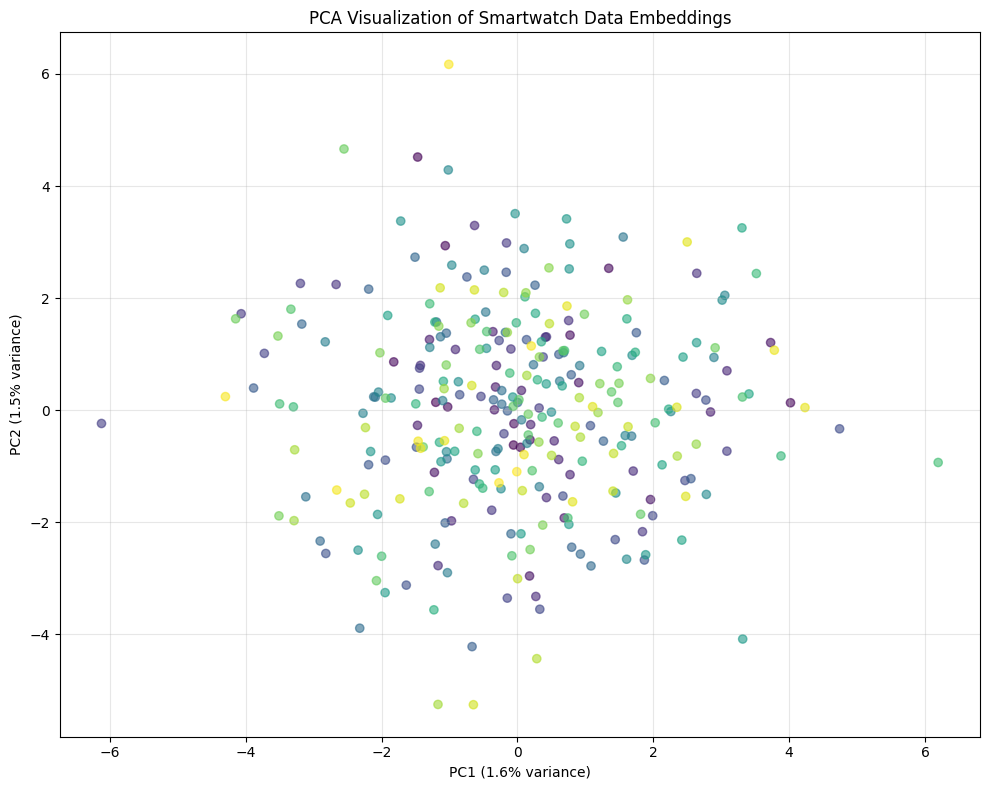


Applying t-SNE for visualization...


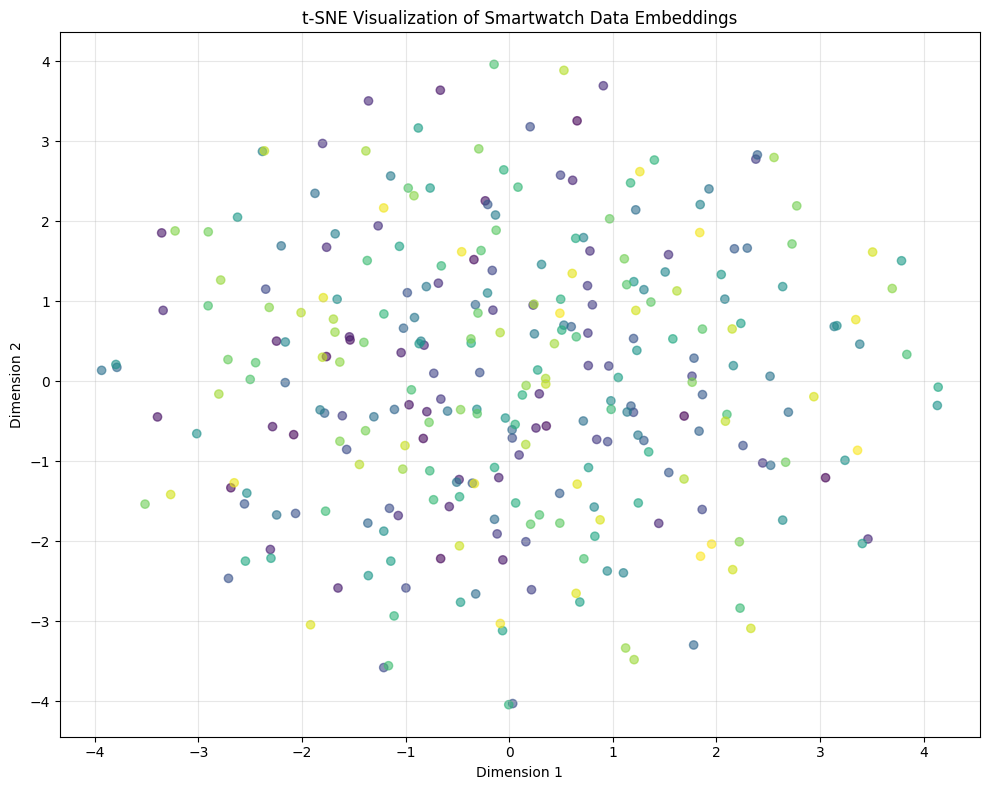


Embedding Statistics:
Shape: (300, 200)
Min value: -4.337512969970703
Max value: 4.282660961151123
Mean value: -2.38418573772492e-09
Standard deviation: 0.9999999403953552


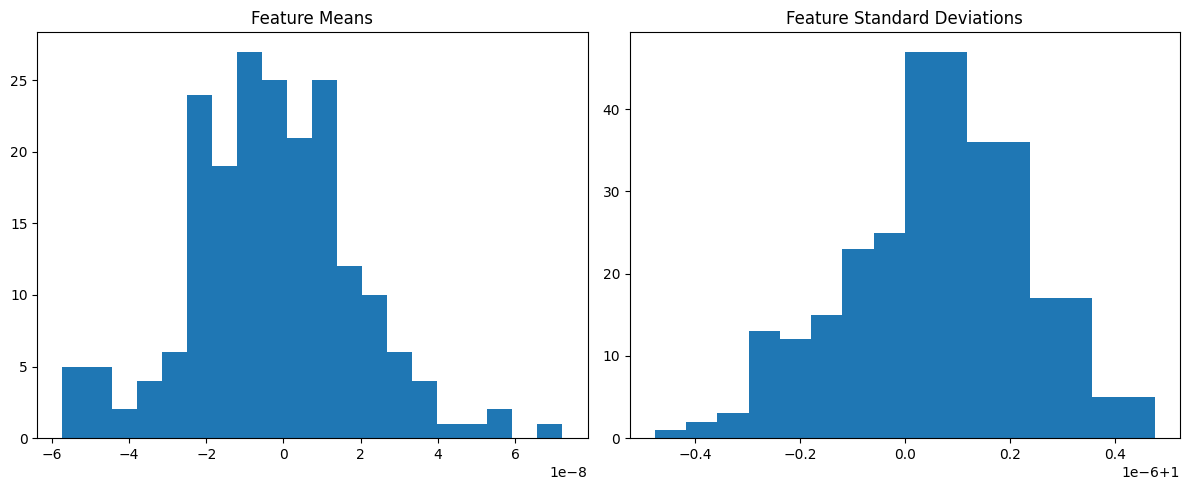

In [13]:
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import pickle
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

def visualize_from_file(filename='smartwatch_embeddings.pkl', n_samples=300):
    """
    Directly visualize embeddings from a file without needing the model.

    Args:
        filename: Path to the pickled embeddings file
        n_samples: Number of samples to visualize
    """
    try:
        # Load embeddings from file
        with open(filename, 'rb') as f:
            data = pickle.load(f)

        embeddings = data['embeddings']
        print(f"Loaded embeddings shape: {embeddings.shape}")

        # Define SimpleGenerator class with the necessary methods
        class SimpleGenerator:
            def __init__(self, embeddings):
                self.embeddings = embeddings

            def preprocess_embeddings(self, embeddings_subset):
                # Check if we have 3D embeddings (batch, sequence, features)
                if len(embeddings_subset.shape) == 3:
                    print(f"Embeddings subset shape before flattening: {embeddings_subset.shape}")
                    embeddings_flat = embeddings_subset.mean(dim=1)
                    print(f"Embeddings shape after time-averaging: {embeddings_flat.shape}")
                else:
                    embeddings_flat = embeddings_subset

                # Convert to numpy for easier processing
                embeddings_np = embeddings_flat.detach().cpu().numpy()
                print(f"Embeddings NumPy array shape: {embeddings_np.shape}")

                # Count and report NaN values
                nan_mask = np.isnan(embeddings_np)
                nan_count = nan_mask.sum()
                print(f"Total NaN values: {nan_count} ({nan_count/(embeddings_np.size)*100:.1f}%)")

                # Replace NaNs with random small values
                if nan_count > 0:
                    print("Replacing NaN values with small random numbers...")
                    np.random.seed(42)  # For reproducibility
                    embeddings_np[nan_mask] = np.random.normal(0, 0.01, size=nan_count)

                # Scale data for numerical stability
                print("Scaling data for numerical stability...")
                # Center data around mean
                embeddings_centered = embeddings_np - np.mean(embeddings_np, axis=0)
                # Scale to unit variance
                std = np.std(embeddings_centered, axis=0)
                # Handle zeros in std to avoid division by zero
                std[std < 1e-10] = 1.0
                embeddings_scaled = embeddings_centered / std

                # Check if scaling introduced any NaNs or infs
                if np.isnan(embeddings_scaled).any() or np.isinf(embeddings_scaled).any():
                    print("Warning: Scaling introduced NaNs/Infs. Using robust method...")
                    # Use robust scaling technique
                    embeddings_scaled = embeddings_np.copy()
                    # Scale each feature using robust methods (median and IQR)
                    for i in range(embeddings_np.shape[1]):
                        column = embeddings_np[:, i]
                        median = np.median(column)
                        q75, q25 = np.percentile(column, [75, 25])
                        iqr = q75 - q25 if q75 > q25 else 1.0
                        embeddings_scaled[:, i] = (column - median) / iqr

                # Final check for any remaining problematic values
                embeddings_scaled = np.nan_to_num(embeddings_scaled, nan=0.0, posinf=1.0, neginf=-1.0)

                return embeddings_scaled

            def visualize_embeddings(self, n_samples=300, labels=None):
                """
                Visualize embeddings using dimensionality reduction techniques.

                Args:
                    n_samples: Number of samples to visualize
                    labels: Optional array of labels for coloring points
                """
                if self.embeddings is None:
                    print("No embeddings to visualize.")
                    return

                print(f"Original embeddings shape: {self.embeddings.shape}")

                # Take a smaller subset for visualization
                if len(self.embeddings) > n_samples:
                    indices = np.random.choice(
                        len(self.embeddings), n_samples, replace=False
                    )
                    embeddings_subset = self.embeddings[indices]
                    if labels is not None:
                        labels_subset = [labels[i] for i in indices]
                    else:
                        labels_subset = None
                else:
                    embeddings_subset = self.embeddings
                    labels_subset = labels

                # Preprocess embeddings to handle NaNs and scale appropriately
                clean_embeddings = self.preprocess_embeddings(embeddings_subset)

                # Store successful visualizations
                visualizations = []

                # 1. Try PCA first
                try:
                    print("\nApplying PCA for visualization...")
                    pca = PCA(n_components=2, random_state=42)
                    embeddings_pca = pca.fit_transform(clean_embeddings)
                    explained_var = pca.explained_variance_ratio_
                    print(f"PCA explained variance: {explained_var[0]:.2f}, {explained_var[1]:.2f}")

                    # Create PCA plot
                    plt.figure(figsize=(10, 8))
                    if labels_subset is not None:
                        scatter = sns.scatterplot(
                            x=embeddings_pca[:, 0],
                            y=embeddings_pca[:, 1],
                            hue=labels_subset,
                            palette='viridis',
                            alpha=0.7
                        )
                        plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
                    else:
                        plt.scatter(
                            embeddings_pca[:, 0],
                            embeddings_pca[:, 1],
                            alpha=0.6,
                            c=np.arange(len(embeddings_pca)),
                            cmap='viridis'
                        )

                    plt.title('PCA Visualization of Smartwatch Data Embeddings')
                    plt.xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
                    plt.ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
                    plt.grid(alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                    print(f"Error during PCA: {str(e)}")

                # 2. Try t-SNE
                try:
                    print("\nApplying t-SNE for visualization...")
                    perplexity = min(30, max(5, clean_embeddings.shape[0] // 10))
                    tsne = TSNE(
                        n_components=2,
                        random_state=42,
                        perplexity=perplexity,
                        init='pca'
                    )
                    embeddings_tsne = tsne.fit_transform(clean_embeddings)

                    # Create t-SNE plot
                    plt.figure(figsize=(10, 8))
                    if labels_subset is not None:
                        scatter = sns.scatterplot(
                            x=embeddings_tsne[:, 0],
                            y=embeddings_tsne[:, 1],
                            hue=labels_subset,
                            palette='viridis',
                            alpha=0.7
                        )
                        plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')
                    else:
                        plt.scatter(
                            embeddings_tsne[:, 0],
                            embeddings_tsne[:, 1],
                            alpha=0.6,
                            c=np.arange(len(embeddings_tsne)),
                            cmap='viridis'
                        )

                    plt.title('t-SNE Visualization of Smartwatch Data Embeddings')
                    plt.xlabel('Dimension 1')
                    plt.ylabel('Dimension 2')
                    plt.grid(alpha=0.3)
                    plt.tight_layout()
                    plt.show()

                except Exception as e:
                    print(f"Error during t-SNE: {str(e)}")

                # Show statistics regardless
                print("\nEmbedding Statistics:")
                print(f"Shape: {clean_embeddings.shape}")
                print(f"Min value: {np.min(clean_embeddings)}")
                print(f"Max value: {np.max(clean_embeddings)}")
                print(f"Mean value: {np.mean(clean_embeddings)}")
                print(f"Standard deviation: {np.std(clean_embeddings)}")

                # Show feature distributions
                try:
                    plt.figure(figsize=(12, 5))
                    plt.subplot(1, 2, 1)
                    plt.title("Feature Means")
                    plt.hist(np.mean(clean_embeddings, axis=0), bins=20)

                    plt.subplot(1, 2, 2)
                    plt.title("Feature Standard Deviations")
                    plt.hist(np.std(clean_embeddings, axis=0), bins=20)

                    plt.tight_layout()
                    plt.show()
                except Exception as e:
                    print(f"Error showing feature distributions: {str(e)}")

        # Create the generator with the loaded embeddings
        generator = SimpleGenerator(embeddings)

        # Visualize the embeddings (without labels)
        generator.visualize_embeddings(n_samples=n_samples, labels=None)

    except Exception as e:
        print(f"Error in visualization: {str(e)}")
        import traceback
        traceback.print_exc()

# For direct usage
if __name__ == "__main__":
    visualize_from_file('smartwatch_embeddings.pkl', n_samples=300)

Creating nodes...


  0%|          | 0/10071 [00:00<?, ?it/s]

Adding sequential edges...


  0%|          | 0/10070 [00:00<?, ?it/s]

Computing nearest neighbors for similarity edges...
Adding similarity edges...


  0%|          | 0/10071 [00:00<?, ?it/s]

Added 14461 similarity edges
Graph construction complete: 10071 nodes, 24521 edges
Graph saved to smartwatch_temporal_graph.gpickle


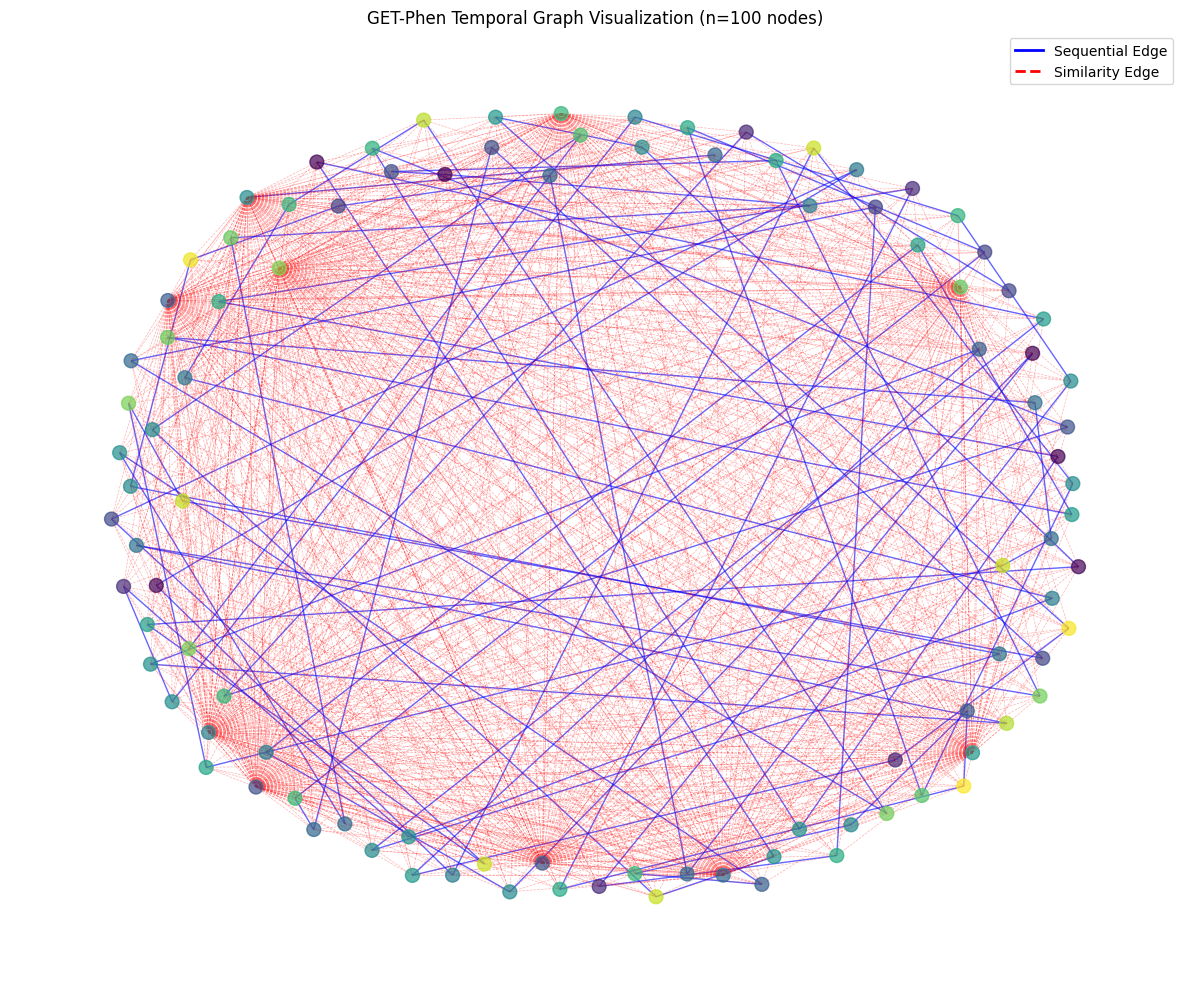

Graph statistics:
Number of nodes: 100
Number of edges: 1089
  - Sequential edges: 89
  - Similarity edges: 1000
Average degree: 21.78


In [17]:
import networkx as nx
import numpy as np
import torch
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
import pickle
import os

class TemporalGraph:
    """
    Class for constructing and manipulating time-evolving graphs from smartwatch embeddings.

    This implements the GET-Phen approach of creating a graph where:
    - Nodes are 1-min window embeddings
    - Sequential edges link t→t+1 nodes
    - Similarity edges link phenotypically-similar windows
    - Node attributes include timestamps and user metadata
    """

    def __init__(self, embeddings, metadata, k_neighbors=5):
        """
        Initialize the temporal graph constructor.

        Args:
            embeddings: Tensor of shape (num_windows, seq_len, latent_dim) or (num_windows, latent_dim)
            metadata: DataFrame with metadata for each window (timestamps, user info, etc.)
            k_neighbors: Number of nearest neighbors for similarity edges
        """
        self.k_neighbors = k_neighbors

        # Convert embeddings to appropriate format
        if len(embeddings.shape) == 3:
            # Average across sequence length dimension
            self.embeddings = embeddings.mean(dim=1)
        else:
            self.embeddings = embeddings

        # Convert to numpy for processing
        if isinstance(self.embeddings, torch.Tensor):
            self.embeddings_np = self.embeddings.detach().cpu().numpy()
        else:
            self.embeddings_np = self.embeddings

        # Handle NaN values in embeddings
        self._clean_embeddings()

        # Store metadata
        self.metadata = metadata

        # Initialize graph
        self.graph = nx.DiGraph()

    def _clean_embeddings(self):
        """Clean embeddings by replacing NaN values with zeros and removing any invalid samples."""
        # Check for NaN values
        nan_mask = np.isnan(self.embeddings_np)
        nan_count = np.sum(nan_mask)

        if nan_count > 0:
            print(f"Warning: Found {nan_count} NaN values in embeddings")

            # Option 1: Replace NaNs with zeros
            self.embeddings_np = np.nan_to_num(self.embeddings_np, nan=0.0)

            # Option 2 (alternative): Remove samples with NaNs
            # bad_indices = np.any(np.isnan(self.embeddings_np), axis=1)
            # if np.sum(bad_indices) > 0:
            #     print(f"Removing {np.sum(bad_indices)} samples with NaN values")
            #     self.embeddings_np = self.embeddings_np[~bad_indices]
            #     # Also filter metadata
            #     self.metadata = self.metadata.iloc[~bad_indices].reset_index(drop=True)

        # Check for infinite values
        inf_mask = np.isinf(self.embeddings_np)
        inf_count = np.sum(inf_mask)

        if inf_count > 0:
            print(f"Warning: Found {inf_count} infinite values in embeddings")
            self.embeddings_np = np.nan_to_num(self.embeddings_np, posinf=1.0, neginf=-1.0)

    def build_graph(self, include_sequential=True, include_similarity=True,
                   lookback_window=1440, similarity_threshold=None):
        """
        Build the time-evolving graph from embeddings.

        Args:
            include_sequential: Whether to include sequential (t→t+1) edges
            include_similarity: Whether to include similarity-based edges
            lookback_window: How many minutes to look back for similarity edges
            similarity_threshold: Optional threshold for similarity edges (cosine similarity)

        Returns:
            G: NetworkX DiGraph object
        """
        num_nodes = len(self.embeddings_np)

        # Create nodes
        print("Creating nodes...")
        for i in tqdm(range(num_nodes)):
            node_data = {
                'embedding': self.embeddings_np[i].tolist(),  # Convert to list for JSON serialization
                'timestamp': self.metadata.iloc[i]['timestamp'] if 'timestamp' in self.metadata.columns else i,
            }

            # Add additional metadata as node attributes
            for col in self.metadata.columns:
                if col != 'timestamp':
                    node_data[col] = self.metadata.iloc[i][col]

            # Add node to graph
            self.graph.add_node(i, **node_data)

        # Add sequential edges (t→t+1)
        if include_sequential:
            print("Adding sequential edges...")
            for i in tqdm(range(num_nodes - 1)):
                self.graph.add_edge(i, i+1, type='sequential', weight=1.0)

        # Add similarity edges using k-NN
        if include_similarity:
            print("Computing nearest neighbors for similarity edges...")

            try:
                # Use sklearn NearestNeighbors for efficient computation
                nbrs = NearestNeighbors(
                    n_neighbors=min(self.k_neighbors + 1, num_nodes),
                    algorithm='auto',  # Changed from 'ball_tree' to 'auto' for more compatibility
                    metric='euclidean'  # Changed from 'cosine' to 'euclidean' for reliability
                ).fit(self.embeddings_np)

                # Get k-NN for each node
                distances, indices = nbrs.kneighbors(self.embeddings_np)

                # Add similarity edges
                print("Adding similarity edges...")
                edges_added = 0

                for i in tqdm(range(num_nodes)):
                    # Get current node timestamp
                    if 'timestamp' in self.metadata.columns:
                        current_time = pd.to_datetime(self.metadata.iloc[i]['timestamp'])
                    else:
                        current_time = i  # Use index as proxy

                    for j in range(1, len(indices[i])):  # Skip first (self)
                        neighbor_idx = indices[i][j]

                        # Convert Euclidean distance to similarity score (inverse relationship)
                        max_dist = np.max(distances)
                        similarity = 1.0 - (distances[i][j] / max_dist)

                        # Check if similarity exceeds threshold (if provided)
                        if similarity_threshold is not None and similarity < similarity_threshold:
                            continue

                        # Check if neighbor is within lookback window
                        if 'timestamp' in self.metadata.columns:
                            neighbor_time = pd.to_datetime(self.metadata.iloc[neighbor_idx]['timestamp'])
                            time_diff = abs((current_time - neighbor_time).total_seconds() / 60)  # in minutes
                        else:
                            time_diff = abs(i - neighbor_idx)  # Use index difference as proxy

                        if time_diff <= lookback_window:
                            # Add edge with similarity weight
                            self.graph.add_edge(
                                neighbor_idx, i,  # Direction is from past to present
                                type='similarity',
                                weight=float(similarity),
                                time_diff=float(time_diff)
                            )
                            edges_added += 1

                print(f"Added {edges_added} similarity edges")

            except Exception as e:
                print(f"Error computing similarity edges: {str(e)}")
                print("Continuing with sequential edges only...")

        print(f"Graph construction complete: {self.graph.number_of_nodes()} nodes, "
              f"{self.graph.number_of_edges()} edges")

        return self.graph

    def save_graph(self, filename='temporal_graph.gpickle'):
        """Save the graph to a file."""
        # Use pickle directly since write_gpickle is deprecated in newer NetworkX versions
        with open(filename, 'wb') as f:
            pickle.dump(self.graph, f, protocol=pickle.HIGHEST_PROTOCOL)
        print(f"Graph saved to {filename}")

    def load_graph(self, filename='temporal_graph.gpickle'):
        """Load the graph from a file."""
        # Use pickle directly since read_gpickle is deprecated in newer NetworkX versions
        with open(filename, 'rb') as f:
            self.graph = pickle.load(f)
        print(f"Graph loaded from {filename}")
        return self.graph

    def visualize_graph(self, max_nodes=100, layout='spring'):
        """
        Visualize a subset of the graph.

        Args:
            max_nodes: Maximum number of nodes to visualize
            layout: Graph layout algorithm ('spring', 'kamada_kawai', etc.)
        """
        if self.graph.number_of_nodes() == 0:
            print("Warning: Graph is empty, nothing to visualize")
            return

        # Take a connected subset for visualization
        if self.graph.number_of_nodes() > max_nodes:
            # Take first max_nodes nodes
            nodes = list(self.graph.nodes())[:max_nodes]
            subgraph = self.graph.subgraph(nodes)
        else:
            subgraph = self.graph

        # Create simplified version for visualization - use undirected graph to avoid arrow rendering issues
        vis_graph = nx.Graph()
        for n in subgraph.nodes():
            vis_graph.add_node(n)

        # Add edges but simplify the attributes
        sequential_edges = []
        similarity_edges = []

        for u, v, data in subgraph.edges(data=True):
            if data.get('type') == 'sequential':
                sequential_edges.append((u, v))
            else:  # similarity
                similarity_edges.append((u, v))

        # Compute positions
        try:
            if layout == 'spring':
                pos = nx.spring_layout(vis_graph, seed=42)
            elif layout == 'kamada_kawai':
                pos = nx.kamada_kawai_layout(vis_graph)
            elif layout == 'circular':
                pos = nx.circular_layout(vis_graph)
            else:
                pos = nx.spring_layout(vis_graph, seed=42)

            # Plot
            plt.figure(figsize=(12, 10))

            # Draw nodes
            if 'activity_level' in self.metadata.columns:
                # Color by activity level
                node_list = list(vis_graph.nodes())
                node_colors = []
                for n in node_list:
                    try:
                        activity = subgraph.nodes[n].get('activity_level', 0)
                        node_colors.append(float(activity))
                    except:
                        node_colors.append(0)

                nx.draw_networkx_nodes(
                    vis_graph, pos,
                    nodelist=node_list,
                    node_color=node_colors,
                    node_size=100,
                    alpha=0.7,
                    cmap='viridis'
                )
            else:
                # Default coloring
                nx.draw_networkx_nodes(
                    vis_graph, pos,
                    node_color='skyblue',
                    node_size=100,
                    alpha=0.7
                )

            # Draw edges by type
            nx.draw_networkx_edges(
                vis_graph, pos,
                edgelist=sequential_edges,
                edge_color='blue',
                alpha=0.6,
                width=1.0
            )

            nx.draw_networkx_edges(
                vis_graph, pos,
                edgelist=similarity_edges,
                edge_color='red',
                alpha=0.3,
                width=0.5,
                style='dashed'
            )

            # Add legend
            from matplotlib.lines import Line2D
            legend_elements = [
                Line2D([0], [0], color='blue', lw=2, label='Sequential Edge'),
                Line2D([0], [0], color='red', lw=2, label='Similarity Edge', linestyle='dashed')
            ]
            plt.legend(handles=legend_elements)

            plt.title(f'GET-Phen Temporal Graph Visualization (n={vis_graph.number_of_nodes()} nodes)')
            plt.axis('off')
            plt.tight_layout()
            plt.show()

            # Print graph stats
            print(f"Graph statistics:")
            print(f"Number of nodes: {subgraph.number_of_nodes()}")
            print(f"Number of edges: {subgraph.number_of_edges()}")
            sequential_count = len(sequential_edges)
            similarity_count = len(similarity_edges)
            print(f"  - Sequential edges: {sequential_count}")
            print(f"  - Similarity edges: {similarity_count}")
            print(f"Average degree: {sum(dict(subgraph.degree()).values()) / subgraph.number_of_nodes():.2f}")

        except Exception as e:
            print(f"Error during graph visualization: {str(e)}")
            import traceback
            traceback.print_exc()

            # Alternative simplified visualization
            print("Attempting simplified visualization...")
            plt.figure(figsize=(10, 8))

            G_simple = nx.Graph()
            G_simple.add_nodes_from(range(min(100, len(subgraph))))
            for i in range(min(99, len(subgraph)-1)):
                G_simple.add_edge(i, i+1)

            pos = nx.spring_layout(G_simple, seed=42)
            nx.draw(G_simple, pos, node_size=50, node_color='skyblue',
                    edge_color='gray', with_labels=False)
            plt.title("Simplified Graph Visualization (sequential edges only)")
            plt.axis('off')
            plt.tight_layout()
            plt.show()


# Example usage
if __name__ == "__main__":
    # Load the embeddings and metadata
    with open('smartwatch_embeddings.pkl', 'rb') as f:
        data = pickle.load(f)
        embeddings = data['embeddings']

    # Load the original data for metadata
    metadata = pd.read_csv('smartwatch_data.csv')
    metadata = metadata.iloc[:len(embeddings)]  # Match with embeddings

    # Create temporal graph
    graph_builder = TemporalGraph(embeddings, metadata, k_neighbors=10)

    # Build the graph
    G = graph_builder.build_graph(
        include_sequential=True,
        include_similarity=True,
        lookback_window=1440,  # 24 hours lookback
        similarity_threshold=0.7  # Only connect if similarity > 0.7
    )

    # Save the graph
    graph_builder.save_graph('smartwatch_temporal_graph.gpickle')

    # Visualize a subset of the graph
    graph_builder.visualize_graph(max_nodes=100, layout='spring')